##### <span style="font-family:Arial; font-weight: 800; font-size:25px;"> Histogramms for max supersaturation !</span>


# Preperations

## Load packages & define output paths

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import scipy.stats

import pickle


In [2]:
from matplotlib import ticker

### some user functions and namelist parameters

In [3]:
# import own functions
from importnb import Notebook

with Notebook(): 
        import functions as fkts
        import namelist as nml
        from set_up_case_dict import *

In [4]:
nml.bd_time

(17398, 21602)

### some constants

In [5]:
savefigs = False

In [6]:
list(dct_all)

['FDT', 'LRD', 'SMD']

# Extract maximum supersaturation


## All data (up- and downfrafts)

### Calculate mean values (based on 3d output) for all data

In [12]:
def fkt_calc_3d_stats(da, z_wg):
    """
    calculate mean, standard deviation, 25 & 75 percentile
    
    in:
        da ... xarray
    z_wg:
        z_weights
        
    """
    wgAVG = da.weighted(z_wg).mean()
    
    da_wg = da.where(da.Z[z_wg > 0])
       
    std   = da_wg.std()
    qu25  = da_wg.quantile(0.25)
    # use the 50th quantile as proxiy for median 
    ## (median not possible in weighed array)
    qu50  = da_wg.quantile(0.50) 
    qu75  = da_wg.quantile(0.75)
    
    qu01  = da_wg.quantile(0.01)
    qu99  = da_wg.quantile(0.99)
    
    IQR = qu75 - qu25
    # get whiskers (for boxplot)
    whisker_lo = qu25 - 1.5 *IQR
    whisker_hi = qu75 + 1.5 *IQR
    dct_istat = {"means3d": wgAVG.data,\
                 "std3d": std.data,\
                 "qu25": qu25.data,\
                 "qu50": qu50.data,\
                 "qu75": qu75.data,\
                 "qu01": qu01.data,\
                 "qu99": qu99.data
                }
    
    return dct_istat

In [13]:
def fkt_calc_3d_means(dir_nc):

    ## select case
    #ids_all = xr.open_dataset(dir_nc)
    with xr.open_dataset(dir_nc) as ids_all:
    
        # subset time and calculate time averave
        time_idx  = (ids_all.time >= nml.bd_time[0]) &\
                    (ids_all.time <= nml.bd_time[1])
        
        if not np.any(time_idx):
            time_idx  = (ids_all.time >=ids_all.time[-1]-3600/2) &\
                        (ids_all.time <=  ids_all.time[-1])
            print("WARNING: chosen time not available! Using last 30min of simulation")
                
                
        ids_sub = ids_all.isel(time = time_idx )
        # calculate the distance between the grid boxes
        z_bd = ids_all["Z_BD"]

        # calculate z weights by calculating the height of the grid boxes
        z_weights = z_bd[:,1] - z_bd[:,0]

        #### select only some variables (makes computation quicker)
        ids_sub_vars = ids_sub[["RH", "W"]]


        ## supersaturated pixels only
        ids_sub_vars_ss = ids_sub_vars.where(ids_sub["RH"] >= 100)
        # get number of px with RH>100
        frct_obs = ((ids_sub["RH"] >= 100).sum() / (ids_sub["RH"].size)).data
        
        # initalize return dict
        icase_stats = {}
        
        ihelp = fkt_calc_3d_stats(da = ids_sub_vars_ss["RH"], z_wg = z_weights)
        ihelp.update({"RH_FRACTobs":frct_obs})
        
        # in supersaturation in saturated pixels
        icase_stats.update({"maxS_saturated":ihelp})   


    return icase_stats

In [14]:
# create empty dict to store stats
dct_stats = {}

for sgrp in dct_all:
    itype_dict = {}
    for stype in dct_all[sgrp]:        
        cases_dict = {}
        
        for scase in dct_all[sgrp][stype]:
            cases_dict.update({scase:{}})
        
        itype_dict.update({stype:cases_dict}) 
        
    dct_stats.update({sgrp:itype_dict})


In [15]:
# check out maximum supersaturation for saturated regions
for sgrp in list(dct_all):
    for stype in list(dct_all[sgrp]):
        

        # loop through all cases
        for icase in range(len(dct_all[sgrp][stype])):
        #for icase in range(1):
            scase = sorted(list(dct_all[sgrp][stype]))[icase]
            print(sgrp, stype, scase, sep = "/")


            ## calculate the statistics
            icase_stats = fkt_calc_3d_means(dir_nc = dct_all[sgrp][stype][scase]["dir_3d"])

            ####### Max supersaturation
            dct_stats[sgrp][stype][scase] = icase_stats["maxS_saturated"]

FDT/dt_1e-1_r0_1e-6/10e07
FDT/dt_1e-1_r0_1e-6/10e08
FDT/dt_1e-1_r0_1e-6/10e09
FDT/dt_1e-1_r0_1e-6/10e10
FDT/dt_1e-1_r0_1e-6/65e06
FDT/dt_1e-1_r0_rwet/10e07
FDT/dt_1e-1_r0_rwet/10e08
FDT/dt_1e-1_r0_rwet/10e09
FDT/dt_1e-1_r0_rwet/10e10
FDT/dt_1e-1_r0_rwet/50e07
FDT/dt_1e-1_r0_rwet/65e06
FDT/dt_1e-1_r0_rwet_noREN/10e07
FDT/dt_1e-1_r0_rwet_noREN/10e08
FDT/dt_1e-1_r0_rwet_noREN/10e09
FDT/dt_1e-1_r0_rwet_noREN/10e10
FDT/dt_1e-1_r0_rwet_noREN/50e07
FDT/dt_1e-1_r0_rwet_noREN/65e06
LRD/r0_01e-06/10e07
LRD/r0_01e-06/10e08
LRD/r0_01e-06/10e09
LRD/r0_01e-06/10e10
LRD/r0_01e-06/50e07
LRD/r0_01e-06/65e06
LRD/r0_05e-06/10e07
LRD/r0_05e-06/10e08
LRD/r0_05e-06/10e09
LRD/r0_05e-06/10e10
LRD/r0_05e-06/50e07
LRD/r0_05e-06/65e06
LRD/r0_10e-06/10e07
LRD/r0_10e-06/10e08
LRD/r0_10e-06/10e09
LRD/r0_10e-06/10e10
LRD/r0_10e-06/50e07
LRD/r0_10e-06/65e06
SMD/r0_010e-7/10e07
SMD/r0_010e-7/10e08
SMD/r0_010e-7/10e09
SMD/r0_010e-7/10e10
SMD/r0_010e-7/50e07
SMD/r0_010e-7/65e06
SMD/r0_020e-7/10e07
SMD/r0_020e-7/10e08
SM

In [16]:
print("Done")

Done


#### plot based on 3d data

In [17]:
unq_scase = []
unq_stype = []
for sgrp in dct_all:
    for stype in dct_all[sgrp]:
        if stype not in unq_stype:
            unq_stype.append(stype)
        for scase in dct_all[sgrp][stype]:
            if scase not in unq_scase:
                unq_scase.append(scase)

In [18]:
unq_scase = [unq_scase[i] for i in np.argsort(np.array(unq_scase, dtype = float))]

In [19]:
unq_scase

['65e06', '10e07', '50e07', '10e08', '10e09', '10e10']

In [20]:
unq_stype

['dt_1e-1_r0_1e-6',
 'dt_1e-1_r0_rwet',
 'dt_1e-1_r0_rwet_noREN',
 'r0_01e-06',
 'r0_05e-06',
 'r0_10e-06',
 'r0_010e-7',
 'r0_020e-7',
 'r0_030e-7',
 'r0_040e-7',
 'r0_050e-7',
 'r0_060e-7',
 'r0_070e-7',
 'r0_080e-7',
 'r0_090e-7',
 'r0_100e-7',
 'rwet']

In [21]:
unq_scase

['65e06', '10e07', '50e07', '10e08', '10e09', '10e10']

In [22]:
# set list of unique cases manuall
# (dont plot the rest)
unq_scase = ['65e06', '10e08', '10e10']

(([<matplotlib.axis.YTick at 0x7f3495374f70>,
  [Text(0, 0, '0'),
   Text(0, 1, '1'),
   Text(0, 2, '2'),
   Text(0, 3, '3'),
   Text(0, 4, '4'),
   Text(0, 5, '5'),
   Text(0, 6, '6'),
   Text(0, 7, '7'),
   Text(0, 8, '8'),
   Text(0, 9, '9')]),)

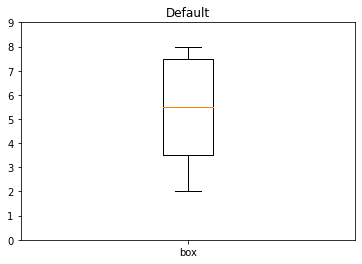

In [23]:


item = {}

item["label"] = 'box' # not required
item["mean"] = 5 # not required
item["med"] = 5.5
item["q1"] = 3.5
item["q3"] = 7.5
#item["cilo"] = 5.3 # not required
#item["cihi"] = 5.7 # not required
item["whislo"] = 2.0 # required
item["whishi"] = 8.0 # required
item["fliers"] = [] # required if showfliers=True

stats = [item]

fig, axes = plt.subplots(1, 1)
axes.bxp(stats)
axes.set_title('Default')
y_axis = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y_values = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
plt.yticks(y_axis, y_values),


In [24]:
dct_all[sgrp][stype][scase]["label"]

'(SMD) $r^d_i$ = $r^a_w$'

In [26]:
## create boxplot statistics

# create a dict to store data
dct_bx = {}
dct_bx_lbl = {}
dct_bx_col = {}
for scase in unq_scase:
    dct_bx.update({scase:[]})
    dct_bx_lbl.update({scase:[]})
    dct_bx_col.update({scase:[]})
    
for sgrp in dct_all:
    for itype in range(len(dct_all[sgrp])):
        stype = list(dct_all[sgrp])[itype]
        idx_stype = np.where(np.array(unq_stype) == stype)[0][0]
        
        for scase in unq_scase:
            if (sgrp+stype+scase == "FDTdt_1e-2_r0_1e-665e06"):
                continue

            item = {}

            item["nr_obs"] = dct_stats[sgrp][stype][scase]["RH_FRACTobs"]
            item["label"] = dct_all[sgrp][stype][scase]["label"]
            item["med"] = (dct_stats[sgrp][stype][scase]["qu50"]-100).flatten()
            item["q1"] = (dct_stats[sgrp][stype][scase]["qu75"]-100).flatten()
            item["q3"] = (dct_stats[sgrp][stype][scase]["qu25"]-100).flatten()
            #item["cilo"] = 5.3 # not required
            #item["cihi"] = 5.7 # not required
            item["whislo"] = (dct_stats[sgrp][stype][scase]["qu01"]-100).flatten() # required
            item["whishi"] = (dct_stats[sgrp][stype][scase]["qu99"]-100).flatten() # required
            item["fliers"] = [] # required if showfliers=True

            dct_bx[scase].append(item)
            dct_bx_col[scase].append(dct_all[sgrp][stype][scase]["color"])
            dct_bx_lbl[scase].append(dct_all[sgrp][stype][scase]["label"])

/opt/conda/lib/python3.9/site-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(v)
/opt/conda/lib/python3.9/site-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(v)
/opt/conda/lib/python3.9/site-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

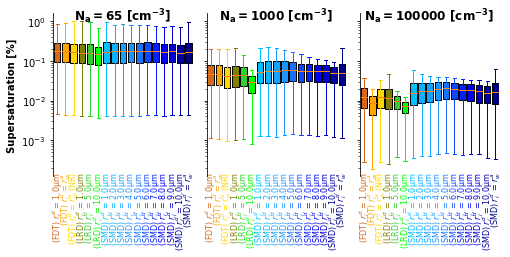

In [27]:
fig, ax = plt.subplots(ncols = len(unq_scase),nrows = 1,\
                       figsize = [8,3], sharey = True)


plt.subplots_adjust(hspace=0.1, wspace = 0.1)
for icase in range(len(unq_scase)):
    scase = unq_scase[icase]
    box = ax[icase].bxp(dct_bx[scase], patch_artist=True, widths = 0.8);


    for icol in range(len(dct_bx_col[scase])):
        box['boxes'][icol].set_facecolor(dct_bx_col[scase][icol])

        box['whiskers'][icol*2].set_color(dct_bx_col[scase][icol])
        box['whiskers'][icol*2+1].set_color(dct_bx_col[scase][icol])

        box['caps'][icol*2].set_color(dct_bx_col[scase][icol])
        box['caps'][icol*2+1].set_color(dct_bx_col[scase][icol])
    
    ax[icase].set_title("$\mathbf{N_a=}$" + "{0:.0f}".format(float(scase)/1e6) + " $\mathbf{[cm^{-3}]}$" ,\
                        fontweight = "bold", y = 0.92)
    
    for color,tick in zip(dct_bx_col[scase],ax[icase].xaxis.get_major_ticks()):
        tick.label1.set_color(color) #set the color property


[iax.tick_params(axis='x',labelsize = 8, labelrotation=90, pad = -5, length = 0) for iax in ax]
[iax.semilogy() for iax in ax]

[iax.spines[ispine].set_visible(False) for iax in ax for ispine in ["top", "right", "bottom"]]

ax[0].set_ylabel("Supersaturation [%]", fontweight = "bold")


if savefigs:
    plt.savefig(os.path.join(nml.dir_output, "supersaturation_statistics_LOG.png"), dpi=600,
                bbox_inches="tight")

/opt/conda/lib/python3.9/site-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(v)
/opt/conda/lib/python3.9/site-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(v)
/opt/conda/lib/python3.9/site-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

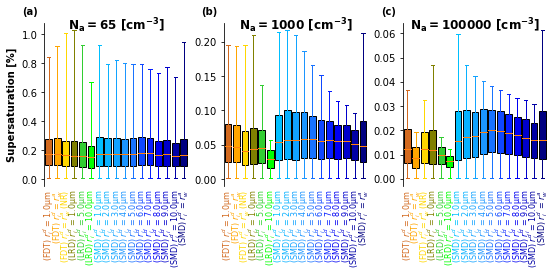

In [28]:
fig, ax = plt.subplots(ncols = len(unq_scase),nrows = 1,\
                       figsize = [9,3], sharey = False)


plt.subplots_adjust(hspace=0.1, wspace = 0.25)
for icase in range(len(unq_scase)):
    scase = unq_scase[icase]
    box = ax[icase].bxp(dct_bx[scase], patch_artist=True, widths = 0.8);


    for icol in range(len(dct_bx_col[scase])):
        box['boxes'][icol].set_facecolor(dct_bx_col[scase][icol])

        box['whiskers'][icol*2].set_color(dct_bx_col[scase][icol])
        box['whiskers'][icol*2+1].set_color(dct_bx_col[scase][icol])

        box['caps'][icol*2].set_color(dct_bx_col[scase][icol])
        box['caps'][icol*2+1].set_color(dct_bx_col[scase][icol])
    
    ax[icase].set_title("$\mathbf{N_a=}$" + "{0:.0f}".format(float(scase)/1e6) + " $\mathbf{[cm^{-3}]}$" ,\
                        fontweight = "bold", y = 0.92)
    
    for color,tick in zip(dct_bx_col[scase],ax[icase].xaxis.get_major_ticks()):
        tick.label1.set_color(color) #set the color property


[iax.tick_params(axis='x',labelsize = 8, labelrotation=90, length = 0,) for iax in ax]

[iax.spines[ispine].set_visible(False) for iax in ax for ispine in ["top", "right", "bottom"]]

ax[0].set_ylabel("Supersaturation [%]", fontweight = "bold")



abcd = "(a)", "(b)", "(c)", "(d)"
for iax in range(len(ax)):
    ax[iax].text(-0.1,1.05, abcd[iax], transform=ax[iax].transAxes, fontweight = "bold",\
                  ha = "center")
    
if savefigs:
    plt.savefig(os.path.join(nml.dir_output, "supersaturation_statistics_noLOG.png"), dpi=600,
                bbox_inches="tight")

/opt/conda/lib/python3.9/site-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(v)
/opt/conda/lib/python3.9/site-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(v)
/opt/conda/lib/python3.9/site-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

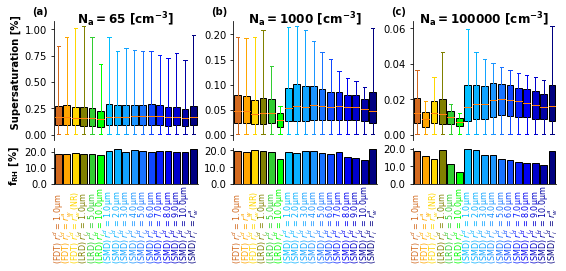

In [29]:
fig, axes = plt.subplots(ncols = len(unq_scase),nrows = 2, figsize = [9,3],\
                         gridspec_kw={'height_ratios': [2.3, 0.7]},\
                         sharey = False, sharex = False)

plt.subplots_adjust(wspace=0.01)
# axes for supersaturation plot
ax_sup = axes[0,:]

# axes for nr observations plot
ax_nrobs = axes[1,:]


plt.subplots_adjust(hspace=0.1, wspace = 0.25)
for icase in range(len(unq_scase)):
    scase = unq_scase[icase]
    box = ax_sup[icase].bxp(dct_bx[scase], patch_artist=True, widths = 0.8);


    for icol in range(len(dct_bx_col[scase])):
        box['boxes'][icol].set_facecolor(dct_bx_col[scase][icol])

        box['whiskers'][icol*2].set_color(dct_bx_col[scase][icol])
        box['whiskers'][icol*2+1].set_color(dct_bx_col[scase][icol])

        box['caps'][icol*2].set_color(dct_bx_col[scase][icol])
        box['caps'][icol*2+1].set_color(dct_bx_col[scase][icol])
    
    axes[0,icase].set_title("$\mathbf{N_a=}$" + "{0:.0f}".format(float(scase)/1e6) + " $\mathbf{[cm^{-3}]}$" ,\
                        fontweight = "bold", y = 0.92)
            
        
    # add parplot
    helper_nrObs = pd.DataFrame(index = range(len(dct_bx[scase])), columns = {"nrObs"})
    for i in range(len(dct_bx[scase])):
        helper_nrObs.iloc[i]["nrObs"] = dct_bx[scase][i]["nr_obs"]
    ax_nrobs[icase].bar(x = helper_nrObs.index+1, height = helper_nrObs["nrObs"]*100,\
                      color = dct_bx_col[scase], width = 0.8,\
                       edgecolor='black')
    
    # get ticks right
    ax_nrobs[icase].set_xticks(ticks = np.arange(len(dct_bx[scase]))+1)
    ax_nrobs[icase].set_xticklabels(dct_bx_lbl[scase])
    
    # change color of the tick labels
    for color,tick in zip(dct_bx_col[scase],ax_nrobs[icase].xaxis.get_major_ticks()):
        tick.label1.set_color(color) #set the color property
    
for iax in ax_nrobs:
    for tick in iax.get_xticklabels():
        tick.set_verticalalignment("bottom")
        iax.tick_params(axis='x', direction='in',length = 0, pad = 80)
        
[iax.tick_params(axis='x',labelsize = 8, labelrotation=90, length = 0, ) for iax in ax_nrobs]
[iax.tick_params(axis='x',labelsize = 0, labelrotation=0, length = 0,) for iax in ax_sup]


[iax.set_xticks([]) for iax in ax_sup]

[iax.spines[ispine].set_visible(False) for iax in ax_sup for ispine in ["top", "right", "bottom"]]
[iax.spines[ispine].set_visible(False) for iax in ax_nrobs for ispine in ["top", "right"]]

ax_sup[0].set_ylabel("     Supersaturation [%]", fontweight = "bold")

ax_nrobs[0].set_ylabel("$\mathbf{f_{RH}}$ [%]", fontweight = "bold")
for iax in range(len(ax_nrobs)):
    ax_nrobs[iax].set_yticks(np.arange(0,20.1,10))
    ax_nrobs[iax].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

# set xlim of upper panels to xlim of lower panels
for iax in range(axes.shape[1]):
    ax_nrobs[iax].set_xlim(ax_sup[iax].get_xlim())


abcd = "(a)", "(b)", "(c)", "(d)"
for iax in range(axes.shape[1]):
    axes[0,iax].text(-0.1,1.05, abcd[iax], transform = axes[0,iax].transAxes, fontweight = "bold",\
                  ha = "center")
    
if savefigs:
    plt.savefig(os.path.join(nml.dir_output, "supersaturation_statistics_bar_noLOG.png"), dpi=600,
                bbox_inches="tight")